## Plot glacier velocity from ITS_LIVE

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
rink_vel = pd.read_csv('D:/Habitat_model_data/glacier_velocity/Rink_LAT76.2397--LON-60.8807.csv')
ko_vel   = pd.read_csv('D:/Habitat_model_data/glacier_velocity/Kong_Oscar_LAT76.0141--LON-59.7148.csv')
sver_vel = pd.read_csv('D:/Habitat_model_data/glacier_velocity/Sverdrup_LAT75.6355--LON-58.0119.csv')

In [3]:
rink_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],rink_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], rink_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], rink_vel["satellite"])),\
                         coords=dict(time=np.array(rink_vel.mid_date, dtype='datetime64')))

In [4]:
ko_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],ko_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], ko_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], ko_vel["satellite"])),\
                         coords=dict(time=np.array(ko_vel.mid_date, dtype='datetime64')))

In [5]:
sver_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],sver_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], sver_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], sver_vel["satellite"])),\
                         coords=dict(time=np.array(sver_vel.mid_date, dtype='datetime64')))

In [6]:
# order dataset in chronological time
rink_vel_ds_order = rink_vel_ds.sortby("time")
ko_vel_ds_order = ko_vel_ds.sortby("time")
sver_vel_ds_order = sver_vel_ds.sortby("time")

In [137]:
np.unique(sver_vel_ds_order.satellite)

array(['1A', '1B', '2A', '2B', '8.'], dtype=object)

In [42]:
# running mean function from ITS_LIVE github repo
def runningMean(
    mid_dates,
    variable,
    minpts,
    tFreq
):
    """
    mid_dates: center dates of `variable` data [datetime64]
    variable: data to be average
    minpts: minimum number of points needed for a valid value, else filled with nan
    tFreq: the spacing between centered averages in Days, default window size = tFreq*2
    """
    tsmin = pd.Timestamp(np.min(mid_dates))
    tsmax = pd.Timestamp(np.max(mid_dates))
    ts = pd.date_range(start=tsmin, end=tsmax, freq=f"{tFreq}D")
    ts = pd.to_datetime(ts).values
    idx0 = ~np.isnan(variable)
    runmean = np.empty([len(ts) - 1, 1])
    runmean[:] = np.nan
    tsmean = ts[0:-1] # times for final running mean data

    t_np = mid_dates.astype(np.int64)

    for i in range(len(ts) - 1):
        idx = (
            (mid_dates >= (ts[i] - np.timedelta64(int(tFreq / 2), "D")))
            & (mid_dates < (ts[i + 1] + np.timedelta64(int(tFreq / 2), "D")))
            & idx0
        )
        if sum(idx) >= minpts:
            runmean[i] = np.mean(variable[idx])
            tsmean[i] = np.mean(t_np[idx])

    tsmean = pd.to_datetime(tsmean).values
    return (runmean, tsmean)

In [79]:
runmean_rink, ts_rink = runningMean(rink_vel_ds_order.time.values,\
                                    rink_vel_ds_order.velocity.values,5,30)
runmean_ko, ts_ko = runningMean(ko_vel_ds_order.time.values,\
                                ko_vel_ds_order.velocity.values,5,30)
runmean_sver, ts_sver = runningMean(sver_vel_ds_order.time.values,\
                                    sver_vel_ds_order.velocity.values,5,30)

In [70]:
runmean_rink, ts_rink = runningMean(rink_vel_ds_order.time.values,\
                                    rink_vel_ds_order.velocity.values,5,7)
runmean_ko, ts_ko = runningMean(ko_vel_ds_order.time.values,\
                                ko_vel_ds_order.velocity.values,5,7)
runmean_sver, ts_sver = runningMean(sver_vel_ds_order.time.values,\
                                    sver_vel_ds_order.velocity.values,5,7)

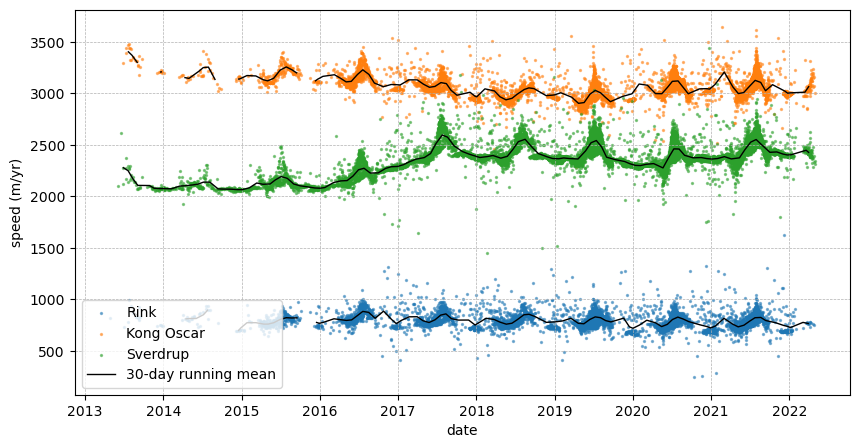

In [80]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(rink_vel_ds_order.time, rink_vel_ds_order.velocity, s=2, alpha=0.5, label='Rink')
plt.scatter(ko_vel_ds_order.time, ko_vel_ds_order.velocity,     s=2, alpha=0.5, label='Kong Oscar')
plt.scatter(sver_vel_ds_order.time, sver_vel_ds_order.velocity, s=2, alpha=0.5, label='Sverdrup')

# plot running mean
plt.plot(ts_rink,runmean_rink, color='k', linewidth=1)
plt.plot(ts_ko,runmean_ko, color='k', linewidth=1)
plt.plot(ts_sver,runmean_sver, color='k', linewidth=1, label='30-day running mean')

plt.legend(loc='lower left')
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("date")
plt.ylabel("speed (m/yr)");

By satellite

In [177]:
groups = ko_vel_ds_order.groupby("satellite")

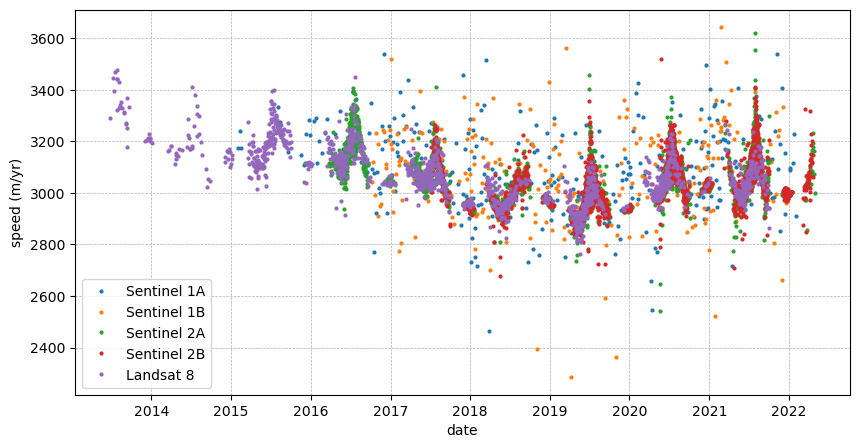

In [178]:
plt.rcParams["figure.figsize"] = (10,5)
    
plt.plot(groups['1A'].time, groups['1A'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 1A')
plt.plot(groups['1B'].time, groups['1B'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 1B')
plt.plot(groups['2A'].time, groups['2A'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 2A')
plt.plot(groups['2B'].time, groups['2B'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 2B')
plt.plot(groups['8.'].time, groups['8.'].velocity, marker='o', linestyle='', markersize=2, label='Landsat 8')

plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("date")
plt.ylabel("speed (m/yr)");

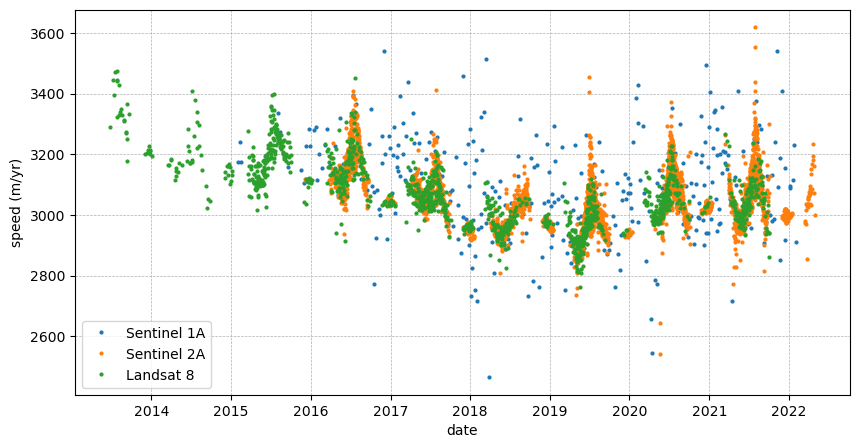

In [159]:
plt.rcParams["figure.figsize"] = (10,5)
    
plt.plot(groups['1A'].time, groups['1A'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 1A')
# plt.plot(groups['1B'].time, groups['1B'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 1B')
plt.plot(groups['2A'].time, groups['2A'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 2A')
# plt.plot(groups['2B'].time, groups['2B'].velocity, marker='o', linestyle='', markersize=2, label='Sentinel 2B')
plt.plot(groups['8.'].time, groups['8.'].velocity, marker='o', linestyle='', markersize=2, label='Landsat 8')

plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("date")
plt.ylabel("speed (m/yr)");

### Select Sentinel 1A, Sentinel 2A, and Landsat 8

In [81]:
# remove 1B and 2B data
rink_vel_ds_filter = rink_vel_ds_order.where(np.logical_and(rink_vel_ds_order.satellite!='1B', rink_vel_ds_order.satellite!='2B'))
ko_vel_ds_filter = ko_vel_ds_order.where(np.logical_and(ko_vel_ds_order.satellite!='1B', ko_vel_ds_order.satellite!='2B'))
sver_vel_ds_filter = sver_vel_ds_order.where(np.logical_and(sver_vel_ds_order.satellite!='1B', sver_vel_ds_order.satellite!='2B'))

In [82]:
rink_groups = rink_vel_ds_filter.groupby("satellite")
ko_groups = ko_vel_ds_filter.groupby("satellite")
sver_groups = sver_vel_ds_filter.groupby("satellite")

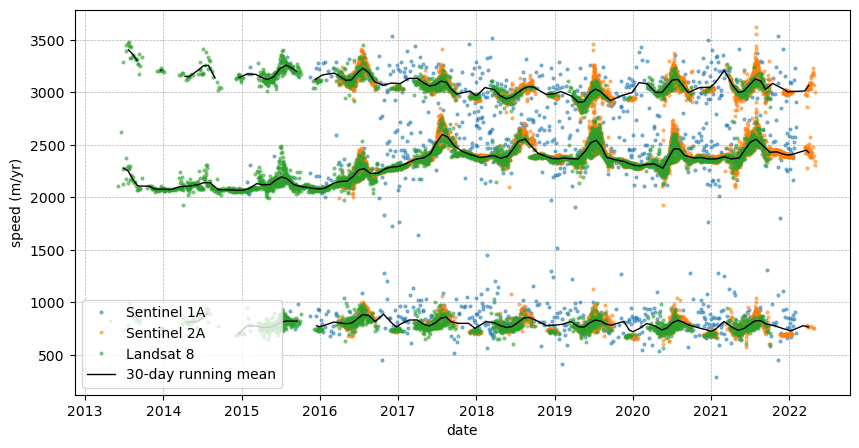

In [83]:
plt.rcParams["figure.figsize"] = (10,5)
    
plt.plot(rink_groups['1A'].time, rink_groups['1A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:blue')
plt.plot(rink_groups['2A'].time, rink_groups['2A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:orange')
plt.plot(rink_groups['8.'].time, rink_groups['8.'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:green')

plt.plot(ko_groups['1A'].time, ko_groups['1A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:blue')
plt.plot(ko_groups['2A'].time, ko_groups['2A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:orange')
plt.plot(ko_groups['8.'].time, ko_groups['8.'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:green')

plt.plot(sver_groups['1A'].time, sver_groups['1A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:blue', label='Sentinel 1A')
plt.plot(sver_groups['2A'].time, sver_groups['2A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:orange', label='Sentinel 2A')
plt.plot(sver_groups['8.'].time, sver_groups['8.'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:green', label='Landsat 8')

# plot running mean
plt.plot(ts_rink,runmean_rink, color='k', linewidth=1)
plt.plot(ts_ko,runmean_ko, color='k', linewidth=1)
plt.plot(ts_sver,runmean_sver, color='k', linewidth=1, label='30-day running mean')

plt.legend(loc='lower left')
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("date")
plt.ylabel("speed (m/yr)");

Estimate mean velocities for 2018-07-01 to 2020-10-01 period

In [84]:
rink_groups = rink_vel_ds_filter.sel(time=slice('2018-07-01','2020-09-30')).groupby("satellite")
ko_groups = ko_vel_ds_filter.sel(time=slice('2018-07-01','2020-09-30')).groupby("satellite")
sver_groups = sver_vel_ds_filter.sel(time=slice('2018-07-01','2020-09-30')).groupby("satellite")

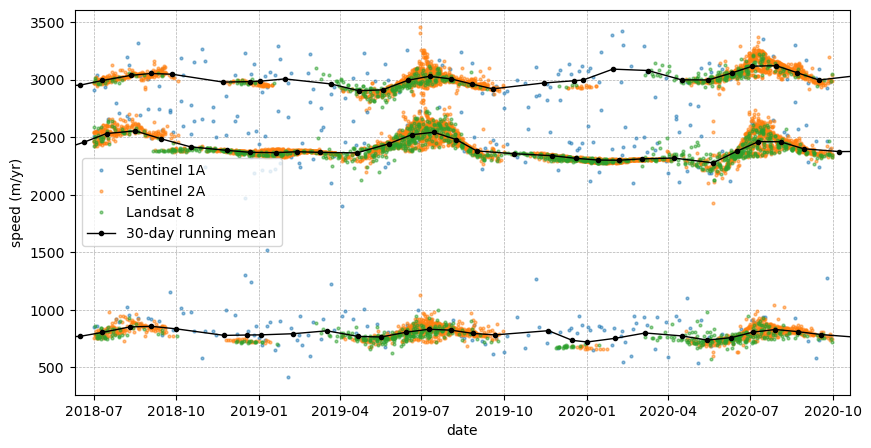

In [85]:
plt.rcParams["figure.figsize"] = (10,5)
    
plt.plot(rink_groups['1A'].time, rink_groups['1A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:blue')
plt.plot(rink_groups['2A'].time, rink_groups['2A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:orange')
plt.plot(rink_groups['8.'].time, rink_groups['8.'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:green')

plt.plot(ko_groups['1A'].time, ko_groups['1A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:blue')
plt.plot(ko_groups['2A'].time, ko_groups['2A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:orange')
plt.plot(ko_groups['8.'].time, ko_groups['8.'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:green')

plt.plot(sver_groups['1A'].time, sver_groups['1A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:blue', label='Sentinel 1A')
plt.plot(sver_groups['2A'].time, sver_groups['2A'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:orange', label='Sentinel 2A')
plt.plot(sver_groups['8.'].time, sver_groups['8.'].velocity, marker='o', linestyle='', markersize=2, alpha=0.5, c='tab:green', label='Landsat 8')

# plot running mean
plt.plot(ts_rink,runmean_rink, color='k', marker='.', linewidth=1)
plt.plot(ts_ko,runmean_ko, color='k', marker='.', linewidth=1)
plt.plot(ts_sver,runmean_sver, color='k', marker='.', linewidth=1, label='30-day running mean')

plt.legend()
plt.xlim(np.datetime64('2018-06-10'),np.datetime64('2020-10-20'))
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("date")
plt.ylabel("speed (m/yr)");

In [192]:
print(rink_vel_ds_filter.sel(time=slice('2018-07-01','2020-09-30')).velocity.mean('time').values)
print(ko_vel_ds_filter.sel(time=slice('2018-07-01','2020-09-30')).velocity.mean('time').values)
print(sver_vel_ds_filter.sel(time=slice('2018-07-01','2020-09-30')).velocity.mean('time').values)

799.5246949447995
3028.459663865546
2415.1044282881694
